In [1]:
from smart_open import open
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize

# Load data for goalkeepers

In [2]:
data = pd.read_csv("../data/training_pruned_file_20162021.csv")

In [3]:
players = data.loc[lambda x: x["position"] == "Goalkeeper"]

In [4]:
sorted(players.columns.values)

['accurate_crosses.total',
 'accurate_passes.total',
 'aerials_won.total',
 'agent_name',
 'bench.total',
 'big_chances_created.total',
 'big_chances_missed.total',
 'birth.country',
 'blocked_shots.total',
 'captain.total',
 'cards.red',
 'cards.yellow',
 'cards.yellowred',
 'clearances.total',
 'common_name',
 'continent',
 'country_name',
 'date',
 'date_of_birth',
 'dispossessed.total',
 'dribbled_past.total',
 'dribbles.attempts',
 'dribbles.past',
 'dribbles.success',
 'duels.total',
 'duels.won',
 'duels_won.total',
 'error_lead_to_goal.total',
 'firstname_x',
 'foot',
 'fouls.committed',
 'fouls.drawn',
 'fouls.total',
 'fouls_drawn.total',
 'games.appearences',
 'games.captain',
 'games.lineups',
 'games.minutes',
 'games.number',
 'games.position',
 'games.rating',
 'gender',
 'global_performance',
 'goals.assists',
 'goals.conceded',
 'goals.goals',
 'goals.penalties',
 'goals.saves',
 'goals.total_y',
 'height_x',
 'highest_market_value_in_eur',
 'hit_woodwork.total',
 'int

## Select variables for goalkeepers

In [5]:
players_selected_vars = players[[
    "name",
    "player_id_api",
    "date_of_birth",
    "nationality",
    "team_name",
    'league_name',
     'league.season',
    # "error_lead_to_goal.total",
    "saves_inside_box.total",
    "games.appearences",
    "games.lineups",
    "games.minutes",
    "goals.conceded",
    "goals.saves",
    "penalty.saved",
    # "highest_market_value_in_eur",
    "market_value_in_eur_x",
    "own_goals.total",
]].copy().rename({
    "team_name": "team",
    "league_name": "league",
    "league.season": "season",
    "games.appearences": "matches_played",
    "games.lineups": "matches_started",
    "games.minutes": "minutes",
    "goals.conceded": "goals_against",
    "goals.saves": "saves",
    "saves_inside_box.total": "saves_inside_box",
    "penalty.saved": "penalty_kicks_saves",
    "own_goals.total": "own_goals_against",
    # "error_lead_to_goal.total": "errors_to_goal",
    "market_value_in_eur_x": "market_value",
}, axis=1)
players_selected_vars["90s_played"] = players_selected_vars["minutes"] / 90
# players_selected_vars["goals_against_90s"] = players_selected_vars["goals_against"] / players_selected_vars["90s_played"]
players_selected_vars["shots_on_target_against"] = players_selected_vars["goals_against"] + players_selected_vars["saves"]
players_selected_vars["save%"] = players_selected_vars["saves"] / players_selected_vars["shots_on_target_against"]
players_selected_vars["age"] = pd.to_datetime(players_selected_vars["date_of_birth"]).map(lambda x: int((pd.Timestamp.today() - x).days / 365))
players_selected_vars["own_goals_against"] = players_selected_vars["own_goals_against"].fillna(0)
for per_90 in [
    "shots_on_target_against",
    "saves_inside_box",
    "saves",
    "penalty_kicks_saves",
    "own_goals_against",
    "goals_against",
]:
    players_selected_vars[per_90] = players_selected_vars[per_90] / players_selected_vars["90s_played"]


players_selected_vars.replace([np.inf, -np.inf], np.nan, inplace=True)
    
players_selected_vars = players_selected_vars.drop([
    "date_of_birth",
    "minutes",
], axis=1)

order = [
    "name",
    "player_id_api",
    "age",
    "nationality",
    "league",
    "team",
    "season",
    "matches_played",
    "matches_started",
    # "minutes",
    "90s_played",
    "goals_against",
    "own_goals_against",
    "shots_on_target_against",
    "saves",
    "save%",
    "saves_inside_box",
    "penalty_kicks_saves",
    "market_value",
]
players_selected_vars = players_selected_vars[order + list(set(players_selected_vars.columns).difference(order))]

In [6]:
from helpers import TEAM_TIERS

In [7]:
players_selected_vars = pd.merge(players_selected_vars, TEAM_TIERS, left_on="team", right_index=True)

In [8]:
mvs = players_selected_vars["market_value"].values
mvs = np.expand_dims(mvs, axis=1)
mvs = normalize(mvs, norm="max", axis=0)
mvs = np.squeeze(mvs)
players_selected_vars["normalised_market_value"] = mvs

In [9]:
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

## Transformation pipeline

In [10]:
numeric_features = [
    "age",
    "matches_played",
    "matches_started",
    "90s_played",
    "goals_against",
    "own_goals_against",
    "shots_on_target_against",
    "saves",
    "save%",
    "saves_inside_box",
    "penalty_kicks_saves",
]
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ]
)

categorical_features = [
    "nationality",
    "league",
    "team",
    "tier",
]
categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(handle_unknown="ignore"))
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

# Predict price bucket

In [11]:
bins = [
    0.0025,
    0.005,
    0.01,
    0.025,
    0.05,
    0.1,
    0.25,
    0.5,
    1.0
]
y = np.digitize(players_selected_vars["normalised_market_value"], bins)
X = players_selected_vars

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
random = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", DummyClassifier(strategy="stratified")),
    ]
)
random.fit(X_train, y_train)

balanced_accuracy_score(y_test, random.predict(X_test))

0.09828985854263912

In [14]:
clf = Pipeline(
    steps=[
        ("preprocessor", preprocessor), 
        ("classifier", LogisticRegression()),
    ]
)
clf.fit(X_train, y_train)

balanced_accuracy_score(y_test, clf.predict(X_test))

/Users/jwasilewski/Library/Caches/pypoetry/virtualenvs/models-wTMcHaj6-py3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.41798049024034867

In [15]:
from sklearn.neural_network import MLPClassifier

mlp = Pipeline(
    steps=[
        ("preprocessor", preprocessor), 
        ("classifier", MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(32, 16))),
    ]
)
mlp.fit(X_train, y_train)

y_mlp = mlp.predict(X_test)

balanced_accuracy_score(y_test, y_mlp)

/Users/jwasilewski/Library/Caches/pypoetry/virtualenvs/models-wTMcHaj6-py3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/jwasilewski/Library/Caches/pypoetry/virtualenvs/models-wTMcHaj6-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


0.38161087528377724

## Features importance

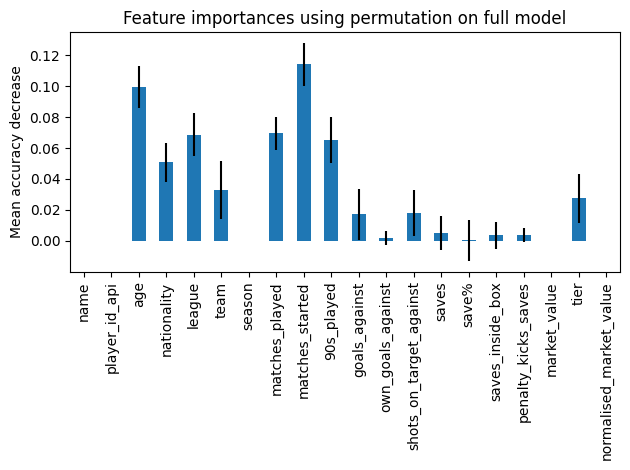

In [16]:
result = permutation_importance(
    mlp, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)

forest_importances = pd.Series(result.importances_mean, index=X_test.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

# Predict market value

In [45]:
def r2_adj(model, x,y):
    r2 = model.score(x,y)
    n = x.shape[0]
    p = x.shape[1]
    return 1-(1-r2)*(n-1)/(n-p-1)

In [46]:
X = players_selected_vars
# y = players_selected_vars["normalised_market_value"]
y = np.log(players_selected_vars["market_value"])

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [48]:
regression = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("regression", LinearRegression()),
    ]
)
regression.fit(X_train, y_train)

regression.score(X_test, y_test), r2_adj(regression, X_test, y_test)

(0.5572818336765388, 0.5283460058122603)

In [49]:
from sklearn.neural_network import MLPRegressor

mlp_reg = Pipeline(
    steps=[
        ("preprocessor", preprocessor), 
        ("regression", MLPRegressor(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(16, 8))),
    ]
)
mlp_reg.fit(X_train, y_train)

mlp_reg.score(X_test, y_test), r2_adj(mlp_reg, X_test, y_test)

/Users/jwasilewski/Library/Caches/pypoetry/virtualenvs/models-wTMcHaj6-py3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


(0.7149319759996117, 0.6963000790061222)

In [50]:
from xgboost import XGBRegressor

xgboost = Pipeline(
    steps=[
        ("preprocessor", preprocessor), 
        ("regression", XGBRegressor()),
    ]
)
xgboost.fit(X_train, y_train)

xgboost.score(X_test, y_test), r2_adj(xgboost, X_test, y_test)

(0.7532473954474979, 0.737119774234916)

## Features importance

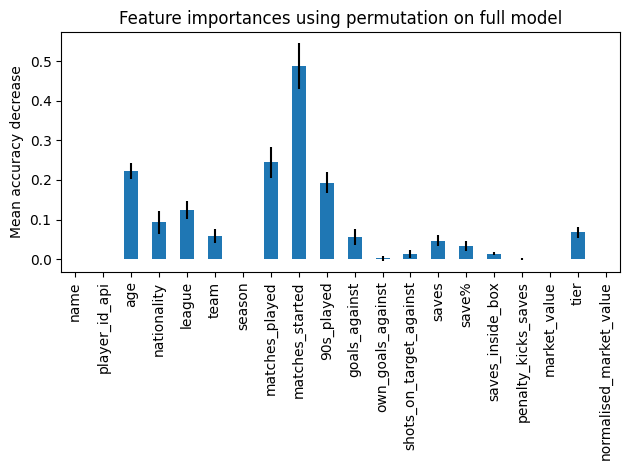

In [22]:
result = permutation_importance(
    mlp_reg, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)

forest_importances = pd.Series(result.importances_mean, index=X_test.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

# Predict change in market value between seasons

In [23]:
before_after_seasons = pd.merge(
    players_selected_vars, 
    players_selected_vars, 
    on="player_id_api", 
    suffixes=["_before", "_after"]
).query("season_after - season_before == 1")

In [24]:
numeric_features_ba = [
    f"{c}_{suffix}" for c in [
        "age",
        "matches_played",
        "matches_started",
        "90s_played",
        "goals_against",
        "own_goals_against",
        "shots_on_target_against",
        "saves",
        "save%",
        "saves_inside_box",
        "penalty_kicks_saves",
    ]
    for suffix in ["before","after"]
]
numeric_transformer_ba = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ]
)

categorical_features_ba = [
    f"{c}_{suffix}" for c in [
        "nationality",
        "league",
        "team",
        "tier",
    ]
    for suffix in ["before","after"]
]
categorical_transformer_ba = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(handle_unknown="ignore"))
    ]
)

preprocessor_ba = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer_ba, numeric_features_ba),
        ("cat", categorical_transformer_ba, categorical_features_ba),
    ]
)

In [25]:
X = before_after_seasons
y_before = np.digitize(before_after_seasons["normalised_market_value_before"], bins)
y_after = np.digitize(before_after_seasons["normalised_market_value_after"], bins)
y = np.minimum(np.maximum(y_after - y_before, -1), 1)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
random = Pipeline(
    steps=[
        ("preprocessor", preprocessor_ba),
        ("classifier", DummyClassifier(strategy="stratified")),
    ]
)
random.fit(X_train, y_train)

balanced_accuracy_score(y_test, random.predict(X_test))

0.43329996663329995

In [28]:
clf = Pipeline(
    steps=[
        ("preprocessor", preprocessor_ba), 
        ("classifier", LogisticRegression()),
    ]
)
clf.fit(X_train, y_train)

print(confusion_matrix(y_test, clf.predict(X_test), labels=[1, 0, -1]))

balanced_accuracy_score(y_test, clf.predict(X_test))

[[ 7 20  0]
 [15 78 18]
 [ 2 27 16]]


/Users/jwasilewski/Library/Caches/pypoetry/virtualenvs/models-wTMcHaj6-py3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.4391725058391725

In [29]:
from sklearn.neural_network import MLPClassifier

mlp = Pipeline(
    steps=[
        ("preprocessor", preprocessor_ba), 
        ("classifier", MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(32, 16))),
    ]
)
mlp.fit(X_train, y_train)

print(confusion_matrix(y_test, mlp.predict(X_test), labels=[1, 0, -1]))

balanced_accuracy_score(y_test, mlp.predict(X_test))

[[ 6 18  3]
 [12 64 35]
 [ 2 20 23]]


0.4366366366366366

In [44]:
from xgboost import XGBClassifier

xgboost = Pipeline(
    steps=[
        ("preprocessor", preprocessor_ba), 
        ("classifier", XGBClassifier()),
    ]
)
xgboost.fit(X_train, y_train+1)

y_xgboost = xgboost.predict(X_test)

balanced_accuracy_score(y_test+1, y_xgboost)

0.5067067067067067

## Features importance

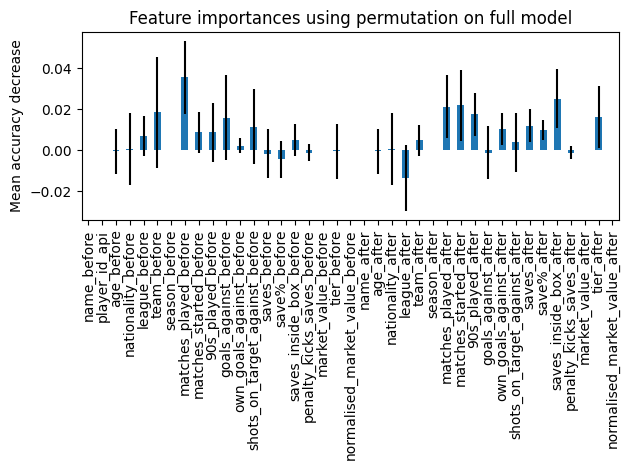

In [30]:
result = permutation_importance(
    clf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)

forest_importances = pd.Series(result.importances_mean, index=X_test.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()